In [37]:
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#stopwords.words('english')

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors


from time import time 
from collections import defaultdict

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [38]:
df_tweets = pd.read_csv("ncr_moretweets.csv", encoding='utf-8')
df_tweets = df_tweets[df_tweets['label'] != 0]

In [39]:
def text_to_word_list(text, tagalog_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = tagalog_letters(text)
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"http\S.*$"," ", text) # removing twitter urls
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", "", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)
    
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
        
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
        
    text = [word for word in text.split(' ') if word not in stopwords.words('english')]
    text = ' '.join(text)
    
    return text

In [40]:
df_tweets.tweets = df_tweets.tweets.apply(lambda x: text_to_word_list(x, unidecode))

In [41]:
import nltk
nltk.download('punkt')
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def preprocess(df_tweets):
    df_tweets['document_sentences'] = df_tweets.tweets.str.split('.') 
    df_tweets['tokenized_sentences'] = list(map(lambda sentences: list(map(nltk.word_tokenize, sentences)), df_tweets.document_sentences))  
    df_tweets['tokenized_sentences'] = list(map(lambda sentences: list(filter(lambda lst: lst, sentences)), df_tweets.tokenized_sentences))

preprocess(df_tweets)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Intel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
df_tweets.head()

,tweets,label,document_sentences,tokenized_sentences
0,awit sa kilala kong nag positive sa covid tas ...,-1,[awit sa kilala kong nag positive sa covid tas...,"[[awit, sa, kilala, kong, nag, positive, sa, c..."
2,yung dinaan na lang sa pagkain yung pagkamiss ...,-1,[yung dinaan na lang sa pagkain yung pagkamiss...,"[[yung, dinaan, na, lang, sa, pagkain, yung, p..."
5,literally miss going without using facemask sh...,-1,[literally miss going without using facemask s...,"[[literally, miss, going, without, using, face..."
6,goddamn covid rip sekou smith influence writin...,-1,[goddamn covid rip sekou smith influence writi...,"[[goddamn, covid, rip, sekou, smith, influence..."
8,sobrang delikado ng ginawa mo kahit saang band...,-1,[sobrang delikado ng ginawa mo kahit saang ban...,"[[sobrang, delikado, ng, ginawa, mo, kahit, sa..."


In [43]:
df_tweets.tokenized_sentences[0]

[['awit',
  'sa',
  'kilala',
  'kong',
  'nag',
  'positive',
  'sa',
  'covid',
  'tas',
  'nag',
  'titinda',
  'padin',
  'ng',
  'pagkain',
  'sa',
  'baclaran',
  'ang',
  'dami',
  'nyong',
  'idadamay',
  'girl',
  'maawa',
  'kayo']]

In [44]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(df_tweets.drop(columns='label'), df_tweets['label'], test_size=.2)

In [45]:
#Collecting a vocabulary
voc = []
for sentence in train.tokenized_sentences:
    voc.extend(sentence)

print("Number of sentences: {}.".format(len(voc)))
print("Number of rows: {}.".format(len(train)))

Number of sentences: 172.
Number of rows: 172.


In [46]:
from gensim.models import word2vec, Word2Vec

num_features = 300    
min_word_count = 3    
num_workers = 4       
context = 8           
downsampling = 1e-3   

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=voc, sg=1, hs=0, workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                    sample=downsampling, negative=5, iter=6)

INFO - 16:20:05: collecting all words and their counts
INFO - 16:20:05: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:20:05: collected 1140 word types from a corpus of 2291 raw words and 172 sentences
INFO - 16:20:05: Loading a fresh vocabulary
INFO - 16:20:05: effective_min_count=3 retains 143 unique words (12% of original 1140, drops 997)
INFO - 16:20:05: effective_min_count=3 leaves 1149 word corpus (50% of original 2291, drops 1142)
INFO - 16:20:05: deleting the raw counts dictionary of 1140 items
INFO - 16:20:05: sample=0.001 downsamples 90 most-common words
INFO - 16:20:05: downsampling leaves estimated 543 word corpus (47.3% of prior 1149)
INFO - 16:20:05: estimated required memory for 143 words and 300 dimensions: 414700 bytes
INFO - 16:20:05: resetting layer weights
INFO - 16:20:05: training model with 4 workers on 143 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=8
INFO - 16:20:05: worker thread finished; awaiting fi

In [47]:
%%time
def sentence_vectors(model, sentence):
    #Collecting all words in the text
#     print(sentence)
    sent_vector = np.zeros(model.vector_size, dtype="float32")
    if sentence == [[]] or sentence == []  :
        return sent_vector
    words=np.concatenate(sentence)
#     words = sentence
    #Collecting words that are known to the model
    model_voc = set(model.wv.vocab.keys()) 
#     print(len(model_voc))

    # Use a counter variable for number of words in a text
    nwords = 0
    # Sum up all words vectors that are know to the model
    for word in words:
        if word in model_voc: 
            sent_vector += model[word]
            nwords += 1.
    # Now get the average
    if nwords > 0:
        sent_vector /= nwords
    return sent_vector

Wall time: 0 ns


In [48]:
W2Vmodel.save('word2vec.model')

INFO - 16:20:05: saving Word2Vec object under word2vec.model, separately None
INFO - 16:20:05: not storing attribute vectors_norm
INFO - 16:20:05: not storing attribute cum_table
INFO - 16:20:05: saved word2vec.model


In [49]:
word_vectors = Word2Vec.load("word2vec.model").wv

INFO - 16:20:05: loading Word2Vec object from word2vec.model
INFO - 16:20:05: loading wv recursively from word2vec.model.wv.* with mmap=None
INFO - 16:20:05: setting ignored attribute vectors_norm to None
INFO - 16:20:05: loading vocabulary recursively from word2vec.model.vocabulary.* with mmap=None
INFO - 16:20:05: loading trainables recursively from word2vec.model.trainables.* with mmap=None
INFO - 16:20:05: setting ignored attribute cum_table to None
INFO - 16:20:05: loaded word2vec.model


<ipython-input-50-88973ea35f08>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vocab = word_vectors.wv.vocab


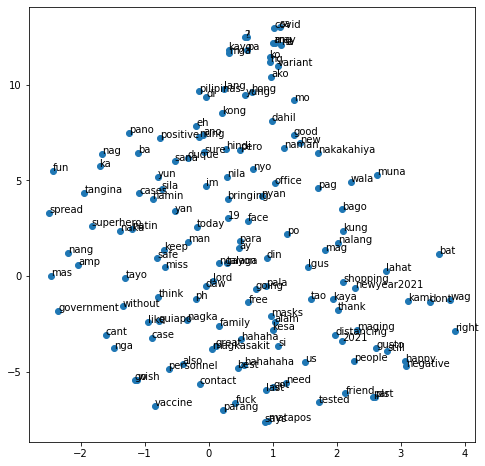

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vocab = word_vectors.wv.vocab
X = word_vectors[vocab]
tsne = TSNE(n_components=2) # Dimension of the embedded space
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)
    
plt.show()

In [51]:
train['sentence_vectors'] = list(map(lambda sen_group:
                                      sentence_vectors(W2Vmodel, sen_group),
                                      train.tokenized_sentences))
test['sentence_vectors'] = list(map(lambda sen_group:
                                    sentence_vectors(W2Vmodel, sen_group), 
                                    test.tokenized_sentences))

<timed exec>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [52]:
def vectors_to_feats(df, ndim):
    index=[]
    for i in range(ndim):
        df[f'w2v_{i}'] = df['sentence_vectors'].apply(lambda x: x[i])
        index.append(f'w2v_{i}')
    return df[index]
X_train = vectors_to_feats(train, 300)
X_train.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_290,w2v_291,w2v_292,w2v_293,w2v_294,w2v_295,w2v_296,w2v_297,w2v_298,w2v_299
216,-0.000328,-0.000386,0.000783,-0.001325,0.004320,-0.000626,-0.001763,0.002660,0.000288,0.002088,...,0.002200,0.000872,0.001846,0.001055,0.002060,-0.001895,0.000258,-0.001100,0.000991,-0.001891
180,-0.000862,-0.000538,-0.000411,-0.000924,0.003564,-0.000851,-0.000782,0.002942,0.000598,0.001306,...,0.001194,0.000850,0.001077,0.001512,0.000718,-0.001364,0.000695,-0.000404,-0.000683,-0.001417
78,-0.000492,-0.000521,-0.000369,-0.001322,0.005080,-0.000592,-0.002453,0.004705,0.001204,0.002939,...,0.001960,0.000918,0.002823,0.001056,0.001878,-0.002209,-0.000481,-0.001804,0.000653,-0.001825
119,-0.000395,-0.000186,0.000385,-0.001607,0.003998,-0.000361,-0.001341,0.002772,0.000790,0.001548,...,0.001743,0.000203,0.002357,0.001340,0.001403,-0.000978,-0.000038,-0.000774,0.000786,-0.001237
64,-0.000378,-0.000321,0.000334,-0.001594,0.003773,-0.000546,-0.001734,0.003119,0.000054,0.002388,...,0.001914,0.000809,0.001446,0.001055,0.002051,-0.002154,-0.000119,-0.001256,0.001138,-0.001905


In [53]:
%%time
test['sentence_vectors'] = list(map(lambda sen_group:sentence_vectors(W2Vmodel, sen_group), test.tokenized_sentences))
X_test=vectors_to_feats(test, 300)

<timed exec>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 204 ms


In [54]:
from sklearn.ensemble import GradientBoostingClassifier
g_boost = GradientBoostingClassifier()
g_boost.fit(X_train, y_train)
y_pred = g_boost.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='micro')))

Testing accuracy 0.7441860465116279
Testing F1 score: 0.7441860465116278


In [55]:
from sklearn.metrics import roc_auc_score, confusion_matrix
print('ROC AUC Score: {}'.format(roc_auc_score(y_test,g_boost.predict_proba(X_test)[:,1])))

ROC AUC Score: 0.6984126984126984


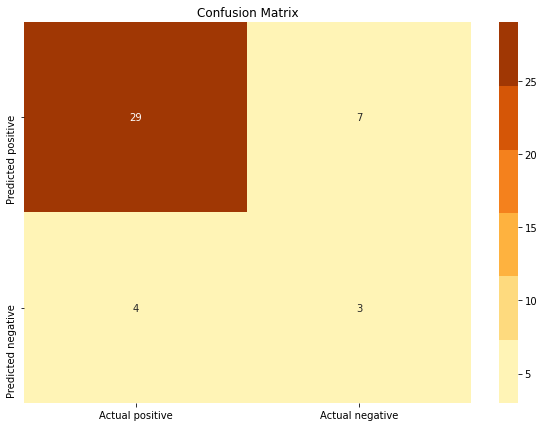

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(confusion_matrix(y_test,g_boost.predict(X_test)), index = ['Predicted positive', 'Predicted negative'],
                  columns = ['Actual positive', 'Actual negative'])
test= sns.color_palette('YlOrBr')
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap=test)
plt.title('Confusion Matrix')
plt.show()

In [57]:
voc_df = []
for sentence_group in df_tweets.tokenized_sentences:
    voc_df.extend(sentence_group)

print("Number of sentences: {}.".format(len(voc_df)))
print("Number of texts: {}.".format(len(df_tweets)))

Number of sentences: 215.
Number of texts: 215.


In [58]:
from gensim.models import word2vec, Word2Vec

num_features = 300    
min_word_count = 3    
num_workers = 4       
context = 8           
downsampling = 1e-3   

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=voc_df, sg=1, hs=0, workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                    sample=downsampling, negative=5, iter=6)

INFO - 16:20:10: collecting all words and their counts
INFO - 16:20:10: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:20:10: collected 1356 word types from a corpus of 2879 raw words and 215 sentences
INFO - 16:20:10: Loading a fresh vocabulary
INFO - 16:20:10: effective_min_count=3 retains 181 unique words (13% of original 1356, drops 1175)
INFO - 16:20:10: effective_min_count=3 leaves 1535 word corpus (53% of original 2879, drops 1344)
INFO - 16:20:10: deleting the raw counts dictionary of 1356 items
INFO - 16:20:10: sample=0.001 downsamples 79 most-common words
INFO - 16:20:10: downsampling leaves estimated 794 word corpus (51.8% of prior 1535)
INFO - 16:20:10: estimated required memory for 181 words and 300 dimensions: 524900 bytes
INFO - 16:20:10: resetting layer weights
INFO - 16:20:10: training model with 4 workers on 181 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=8
INFO - 16:20:10: worker thread finished; awaiting f

In [59]:
%%time
df_tweets['sentence_vectors'] = list(map(lambda sen_group: sentence_vectors(W2Vmodel, sen_group), df_tweets.tokenized_sentences))
df_tweets = vectors_to_feats(df_tweets, 300)
y = pd.read_csv('ncr_moretweets.csv', encoding='utf-8')
y = y[y['label'] != 0]
y = y['label'].values

<timed exec>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Wall time: 222 ms


In [60]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
cv = ShuffleSplit(n_splits=5, random_state=1)

cv_score = cross_val_score(g_boost, df_tweets, y ,cv=cv, scoring='roc_auc')
print(cv_score)
print('CV Mean Score: {}'.format(cv_score.mean()))

[0.68421053 0.54166667 0.63247863 0.51428571 0.59047619]
CV Mean Score: 0.5926235460445988


In [61]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt
!pip install mglearn
import mglearn
import pandas as pd
import pylab as plot
!pip install lmfit
import lmfit as lf
import seaborn as sns
import random
import os
import time
from pandas import Series
from math import sqrt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC, LinearSVC, LinearSVR
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
stratk_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

from sklearn.model_selection import GridSearchCV
param_grids = {'learning_rate': [.2, 0.1, 0.01, 0.05, 0.02, 0.01],
              'max_depth': [3, 4, 6, 10, 14, 16, 18, 20, 40, 60, 80, 100],
              'min_samples_leaf': [2, 3, 4],
              'n_estimators': [100, 200, 300, 400, 500],
              'max_features': [.5,.3, .2] 
}   

In [62]:
#new_df = classification(df_tweets, y)
new_df = pd.read_csv('word2vec_optimized.csv', index_col=0)
new_df = new_df.drop(columns=['f1', 'precision', 'recall'])

In [63]:
import ast 
knn_c = KNeighborsClassifier(n_jobs=-1)
log_res_l1 = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', n_jobs=-1)
log_res_l2 = LogisticRegression(penalty='l2', max_iter=1000, solver='lbfgs', n_jobs=-1)
lin_svc_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
lin_svc_l2 = LinearSVC(penalty='l2', max_iter=10000)
nsvm_rbf = SVC(kernel='rbf')
d_tree = DecisionTreeClassifier(random_state=0)
r_forest = RandomForestClassifier(random_state=0)
g_boost = GradientBoostingClassifier(random_state=0)
    

model_dict = {
    'KNN': knn_c,
    'Logistic Regression (L1)': log_res_l1,
    'Logistic Regression (L2)': log_res_l2,
    'Linear SVM (L1)': lin_svc_l1,
    'Linear SVM (L2)': lin_svc_l2,
    'NonLinear SVM (RBF)': nsvm_rbf,
    'Decision Tree': d_tree,
    'Random Forest': r_forest,
    'XGBoost': g_boost
}

X_train, X_test, y_train, y_test = train_test_split(df_tweets, y, stratify=y, test_size=0.2, random_state=0)
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import ast

def calculate_scores(row):
    current_model = model_dict[row['Model']]
    current_model.set_params(**ast.literal_eval(row['Best Parameters']))
    current_model.fit(X_train, y_train)
    predictions = current_model.predict(X_test)
    row['f1 weighted'] = f1_score(y_test, predictions, average='weighted')
    row['f1 micro'] = f1_score(y_test, predictions, average='micro')
    row['f1 macro'] = f1_score(y_test, predictions, average='macro')
    

    df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = ['Predicted positive', 'Predicted negative'],
                  columns = ['Actual positive', 'Actual negative'])
    colors = sns.color_palette('YlOrBr')
    plt.figure(figsize = (24,12))
    sns.heatmap(df_cm, annot=True, cmap=colors)
    plt.title('Confusion Matrix for ' + row['Model'])
    plt.show()
    plt.savefig('images/' + row['Model'] + ' ' + 'confusion_matrix.png')
    return row
    

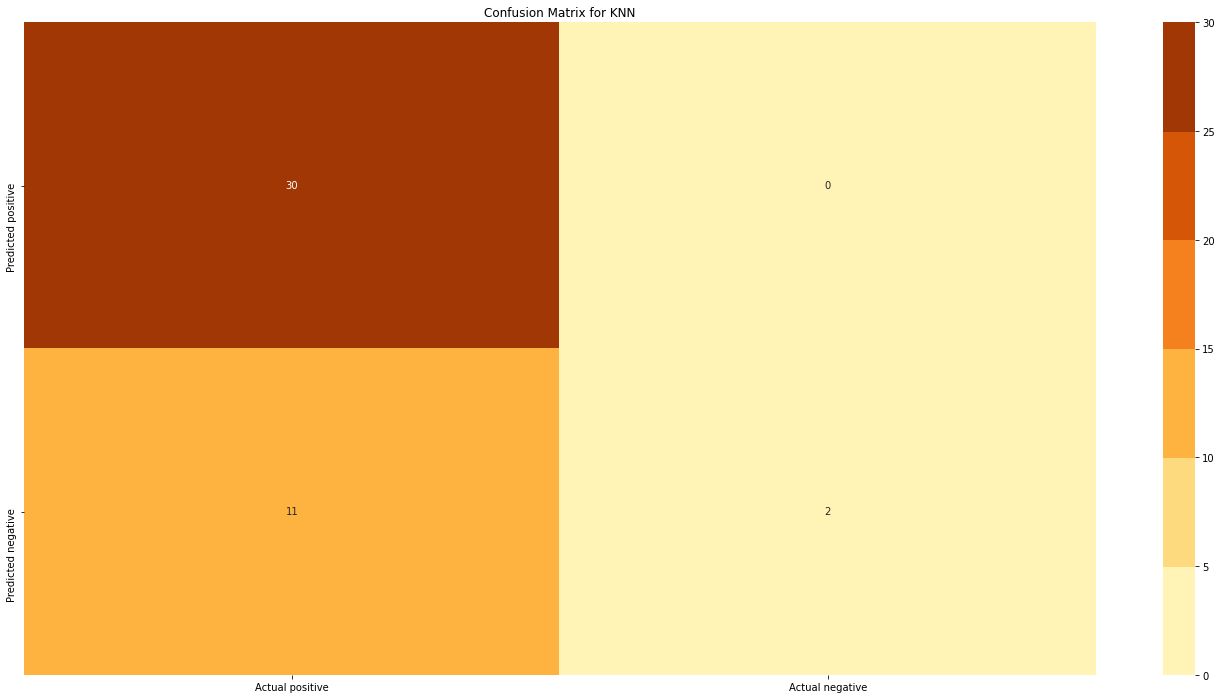

D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


<Figure size 432x288 with 0 Axes>

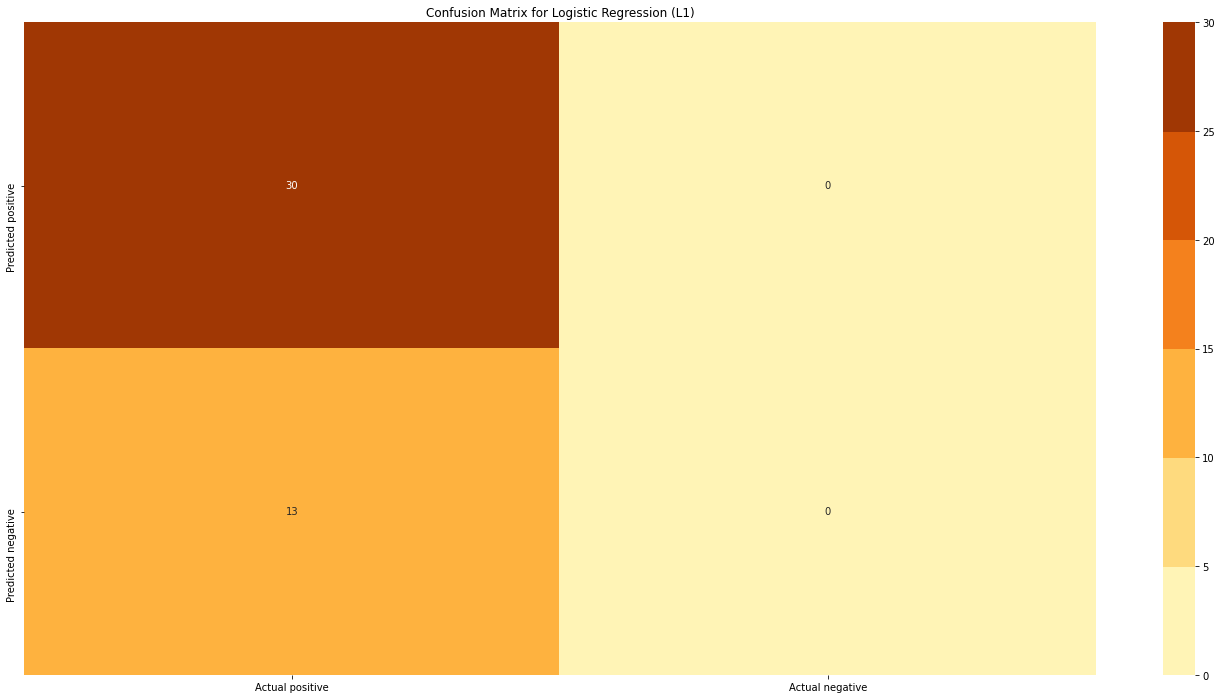

<Figure size 432x288 with 0 Axes>

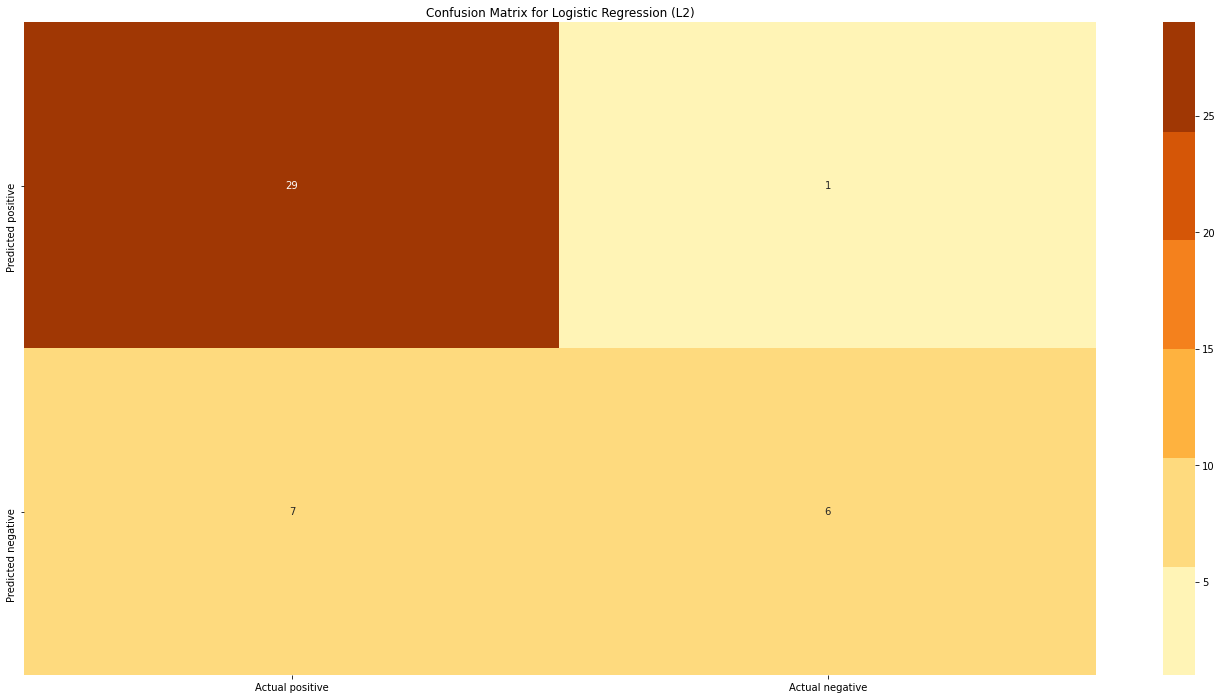

D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<Figure size 432x288 with 0 Axes>

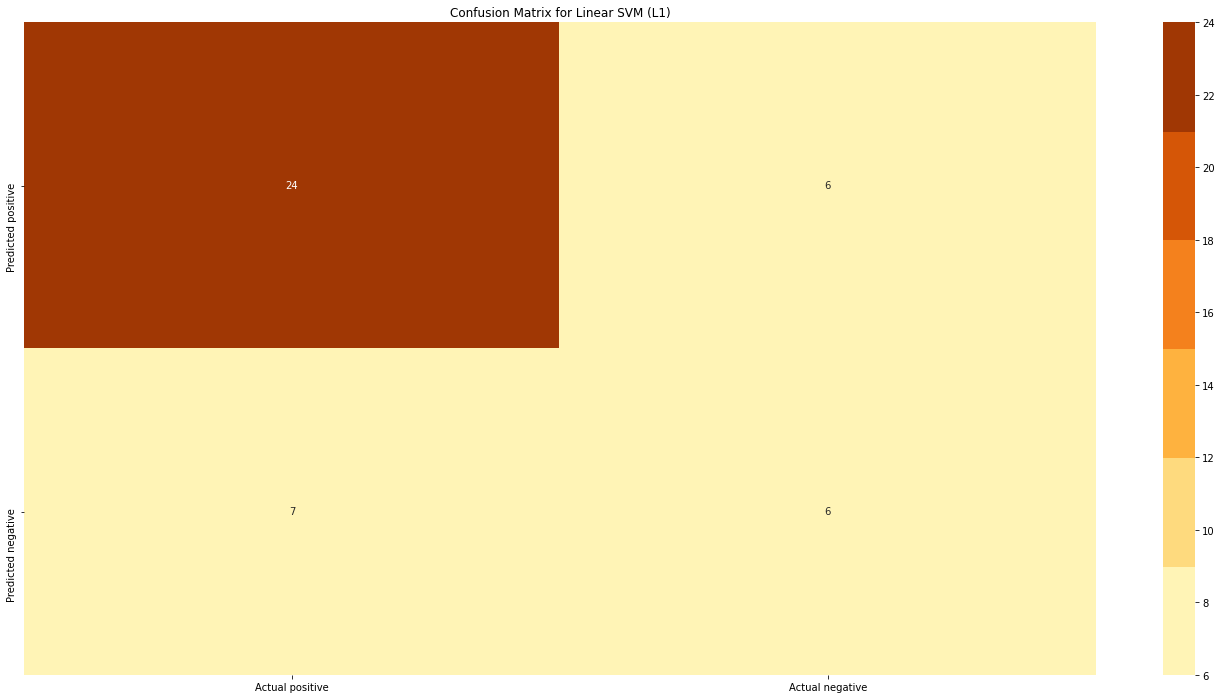

D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


<Figure size 432x288 with 0 Axes>

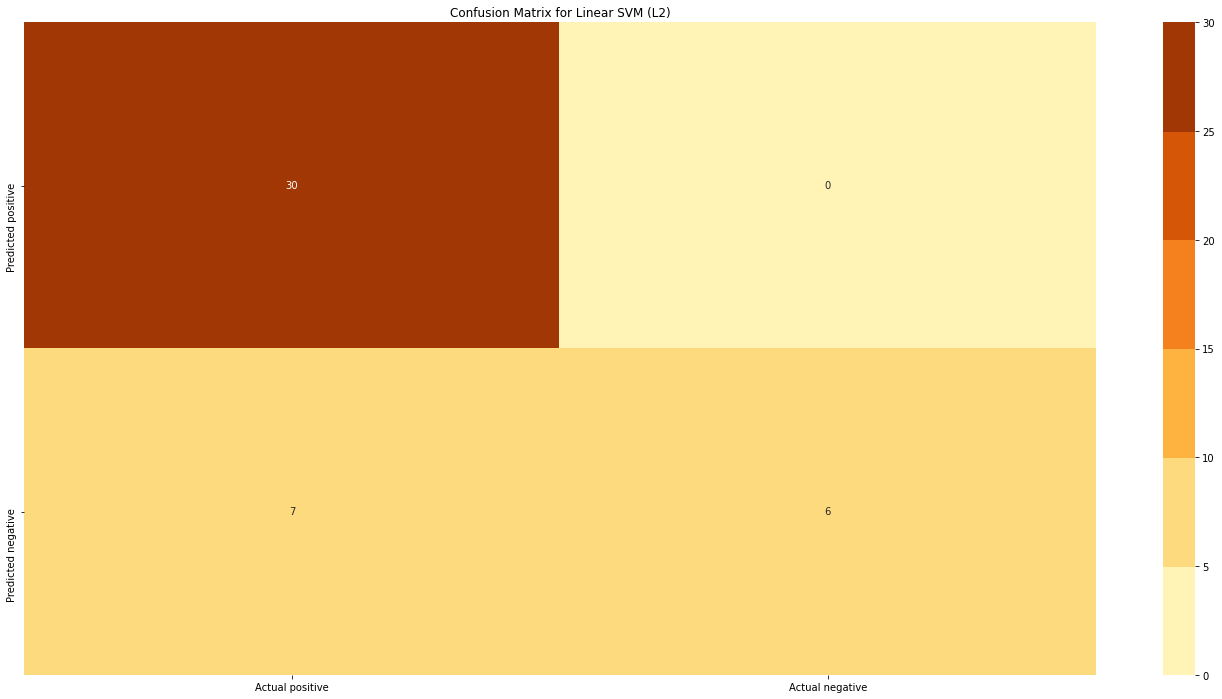

<Figure size 432x288 with 0 Axes>

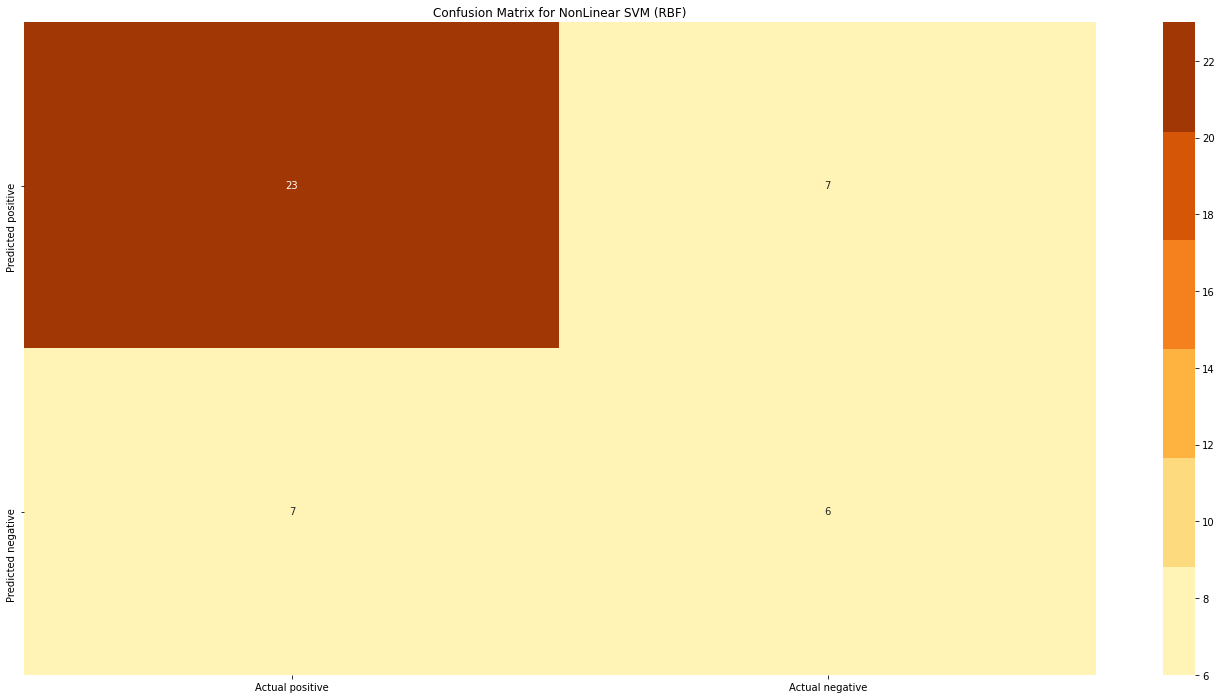

<Figure size 432x288 with 0 Axes>

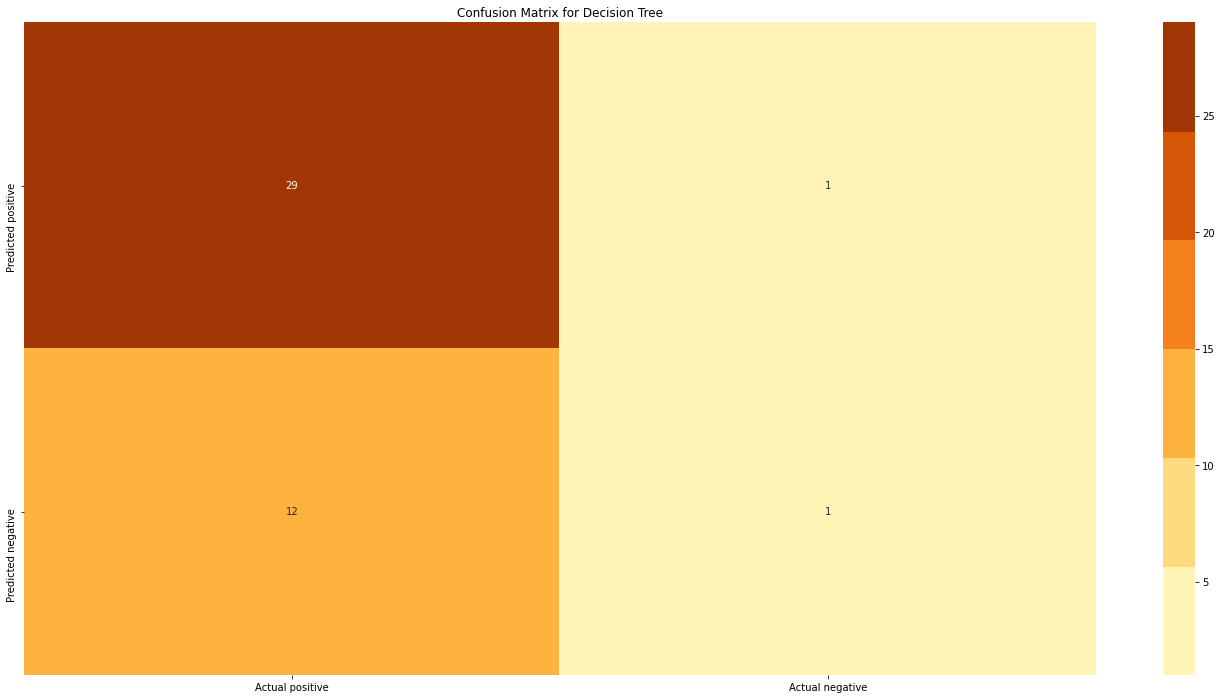

<Figure size 432x288 with 0 Axes>

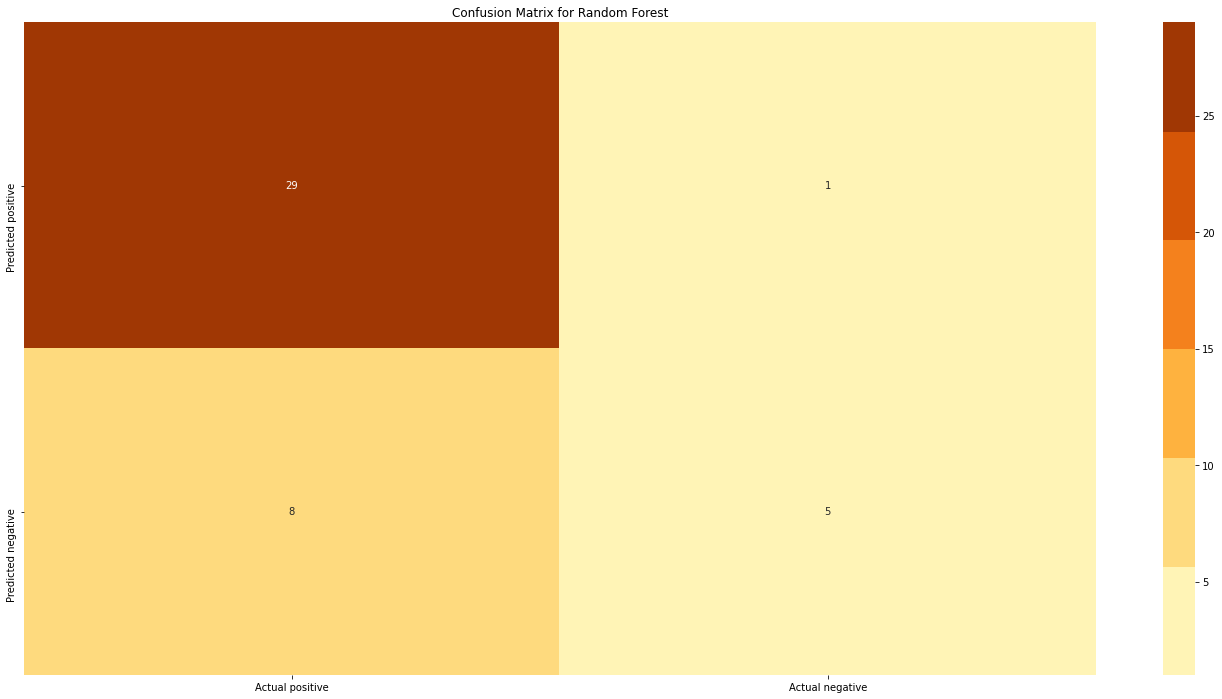

<Figure size 432x288 with 0 Axes>

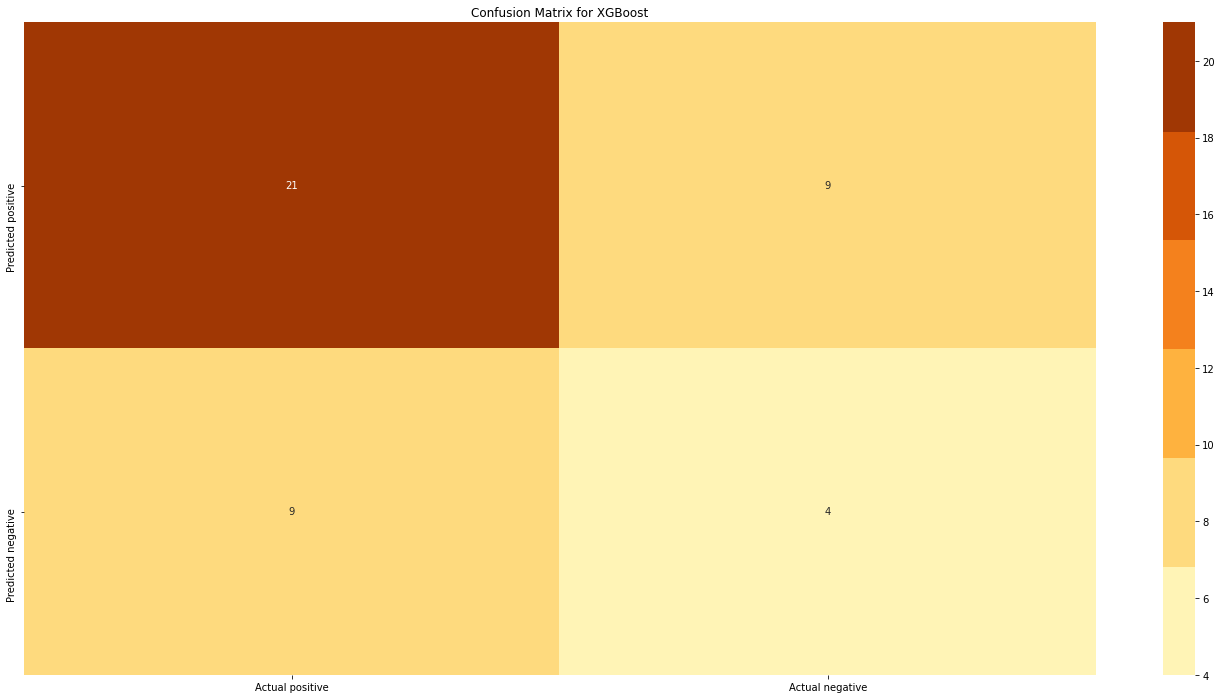

<Figure size 432x288 with 0 Axes>

In [64]:
new_df['Model'] = new_df.index
stats_df = new_df.apply(lambda row: calculate_scores(row), axis=1)

In [65]:
stats_df

,Test Accuracy,Training Accuracy,Best Parameters,Run Time,percent of PCC,Model,f1 weighted,f1 micro,f1 macro
KNN,0.720930,0.761628,{'n_neighbors': 4},5.382352,1.246960,KNN,0.670204,0.744186,0.555869
Logistic Regression (L1),0.697674,0.697674,{'C': 1e-10},1.886265,1.206735,Logistic Regression (L1),0.573431,0.697674,0.410959
Logistic Regression (L2),0.837209,0.848837,{'C': 54555.947811685146},1.935442,1.448082,Logistic Regression (L2),0.794503,0.813953,0.739394
Linear SVM (L1),0.813953,0.970930,{'C': 428.13323987193957},5.957663,1.407858,Linear SVM (L1),0.694106,0.697674,0.633443
Linear SVM (L2),0.790698,0.784884,{'C': 4832.930238571752},7.937805,1.367633,Linear SVM (L2),0.815726,0.837209,0.763551
NonLinear SVM (RBF),0.674419,0.994186,"{'C': 37.92690190732238, 'gamma': 4832.9302385...",6.377883,1.166511,NonLinear SVM (RBF),0.674419,0.674419,0.614103
Decision Tree,-0.145191,0.137483,{'max_depth': 1},2.241006,-0.251131,Decision Tree,0.610241,0.697674,0.475117
Random Forest,0.767442,0.994186,"{'max_depth': 7, 'n_estimators': 100}",342.197690,1.327409,Random Forest,0.763076,0.790698,0.695994
XGBoost,0.744186,0.994186,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",5370.757274,1.287184,XGBoost,0.581395,0.581395,0.503846


In [66]:
#stats_df.to_csv('word2vec_optimized.csv')

In [67]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as XGBClassifier

knn_c = KNeighborsClassifier(n_jobs=-1)
log_res_l1 = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', n_jobs=-1)
log_res_l2 = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
lin_svc_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
lin_svc_l2 = LinearSVC(penalty='l2', max_iter=10000)
# cl7 = SVC(kernel='poly', degree=3)
depth_settings = range(1, 15)
nsvm_rbf = SVC(kernel='rbf')
d_tree = DecisionTreeClassifier(random_state=0, max_depth=depth_settings)
r_forest = RandomForestClassifier(max_depth=depth_settings, random_state=0)
xg_boost = XGBClassifier.XGBClassifier(random_state=0, max_depth=depth_settings, learning_rate=0.01)

model_list = [knn_c, log_res_l1, log_res_l2, lin_svc_l1, lin_svc_l2, nsvm_rbf, d_tree, r_forest, xg_boost]
model_dict = {}

f1_scores_micro = []
f1_scores_macro = []
f1_scores_weighted = []

precision_scores_micro = []
precision_scores_macro = []
precision_scores_weighted = []

recall_scores_micro = []
recall_scores_macro = []
recall_scores_weighted = []

counter = 0
model_predict_df = pd.DataFrame()
for index, row in stats_df.iterrows():
    model_dict[index] = model_list[counter]
    curr_model = model_list[counter]
    print(curr_model)
    curr_model.set_params(**ast.literal_eval(row['Best Parameters']))
    trained_curr_model = curr_model.fit(X_train, y_train)
    predictions = trained_curr_model.predict(X_test)
    
    f1_scores_micro.append(f1_score(predictions, y_test, average='micro'))
    f1_scores_macro.append(f1_score(predictions, y_test, average='macro'))
    f1_scores_weighted.append(f1_score(predictions, y_test, average='weighted'))
    
    precision_scores_micro.append(precision_score(predictions, y_test, average='micro'))
    precision_scores_macro.append(precision_score(predictions, y_test, average='macro'))
    precision_scores_weighted.append(precision_score(predictions, y_test, average='weighted'))
    
    recall_scores_micro.append(recall_score(predictions, y_test, average='micro'))
    recall_scores_macro.append(recall_score(predictions, y_test, average='macro'))
    recall_scores_weighted.append(recall_score(predictions, y_test, average='weighted'))
    
    model_predict_df[index] = predictions
    counter += 1

KNeighborsClassifier(n_jobs=-1)
LogisticRegression(max_iter=1000, n_jobs=-1, penalty='l1', solver='liblinear')
LogisticRegression(max_iter=1000, n_jobs=-1)


D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LinearSVC(dual=False, max_iter=10000, penalty='l1')


D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=10000)


D:\OtherSoftware\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


SVC()
DecisionTreeClassifier(max_depth=range(1, 15), random_state=0)
RandomForestClassifier(max_depth=range(1, 15), random_state=0)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=range(1, 15),
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[16:20:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'l

D:\OtherSoftware\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [68]:
model_predict_df

,KNN,Logistic Regression (L1),Logistic Regression (L2),Linear SVM (L1),Linear SVM (L2),NonLinear SVM (RBF),Decision Tree,Random Forest,XGBoost
0,-1,-1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,1,-1,1,1,1,1,-1,1,1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,1,-1,-1,-1,-1,-1
5,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,-1,-1,-1,1,-1,1,-1,-1,-1
7,-1,-1,-1,-1,-1,1,-1,-1,-1
8,-1,-1,-1,1,-1,-1,-1,-1,-1
9,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [69]:
model_predict_df.to_csv('all_model_predictions.csv')

In [70]:
#new_df

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
g_boost = GradientBoostingClassifier()
g_boost.fit(X_train, y_train)
y_pred = g_boost.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.6744186046511628
Testing F1 score: 0.6549947145877378


In [72]:
knn_model = model_dict['KNN']
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.7441860465116279
Testing F1 score: 0.6702041707610001


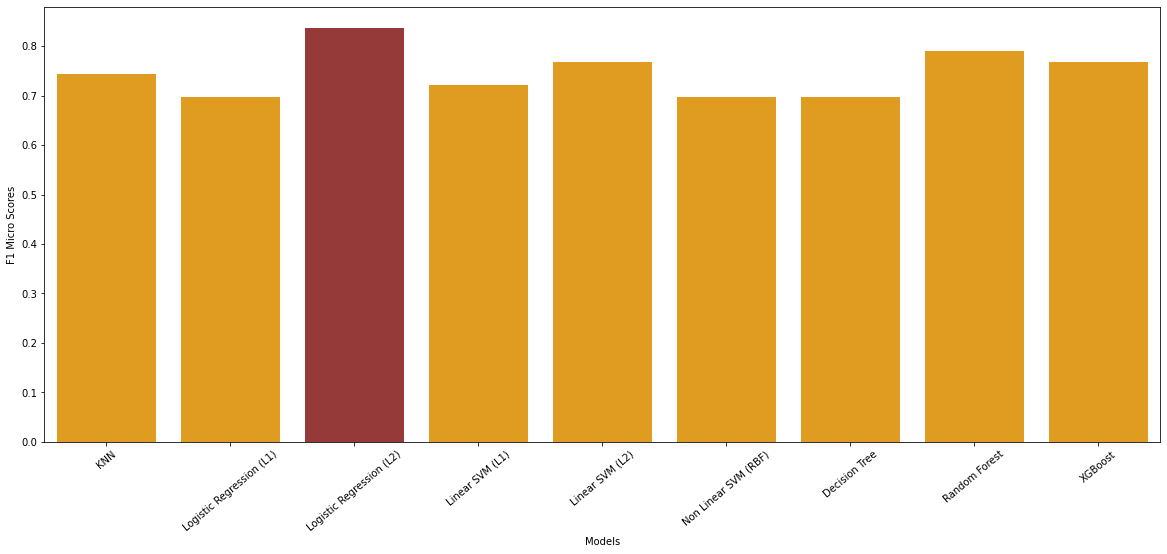

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame()
data = {'Models': ['KNN', 'Logistic Regression (L1)', 'Logistic Regression (L2)', 'Linear SVM (L1)', 'Linear SVM (L2)',
'Non Linear SVM (RBF)', 'Decision Tree', 'Random Forest', 'XGBoost'],
'F1 Micro Scores': [0.744186, 0.697674, 0.837209, 0.720930, 0.767442, 0.697674, 0.697674, 0.790698, 0.767442]}
df = pd.DataFrame(data)
#sns.barplot(x=’Models’, y=’F1 Micro Scores’, data=df, order=df.sort_values(‘F1 Micro Scores’, ascending=False).Models)
#labels = np.array(df.Name)
#values = np.array(df.Score)
test_palette
clrs = ['orange' if (x < max(df['F1 Micro Scores'])) else 'brown' for x in df['F1 Micro Scores'] ]
#Configure the size
plt.figure(figsize=(20,8))
#barplot
sns.barplot(x=df['Models'], y=df['F1 Micro Scores'], data=df, palette=clrs) # color=clrs)
#Rotate x-labels
plt.xticks(rotation=40)
#plt.title(‘F1 Micro Scores of Models’)
plt.show()

In [90]:
model_predict_df['Logistic Regression (L2)']

0    -1
1    -1
2     1
3    -1
4    -1
5    -1
6    -1
7    -1
8    -1
9    -1
10   -1
11    1
12    1
13   -1
14   -1
15   -1
16   -1
17   -1
18   -1
19   -1
20   -1
21   -1
22   -1
23   -1
24   -1
25    1
26    1
27   -1
28   -1
29   -1
30   -1
31   -1
32    1
33   -1
34   -1
35   -1
36    1
37   -1
38   -1
39   -1
40   -1
41   -1
42   -1
Name: Logistic Regression (L2), dtype: int64

In [122]:
l2_predicted_positive = len([val for val in model_predict_df['Logistic Regression (L2)'] if val == 1])
l2_predicted_negative = len([val for val in model_predict_df['Logistic Regression (L2)'] if val == -1])

In [123]:
actual_values_positive = len([val for val in y_test if val == 1])
actual_values_negative = len([val for val in y_test if val == -1])

In [126]:
df_data = {'tweet_count': [actual_values_positive, l2_predicted_positive, actual_values_negative, l2_predicted_negative],
           'data_type': ['actual', 'predicted', 'actual', 'predicted'],
           'sentiment': ['positive', 'positive', 'negative', 'negative']
          }
prediction_comparison = pd.DataFrame(df_data)
prediction_comparison

,tweet_count,data_type,sentiment
0,13,actual,positive
1,7,predicted,positive
2,30,actual,negative
3,36,predicted,negative


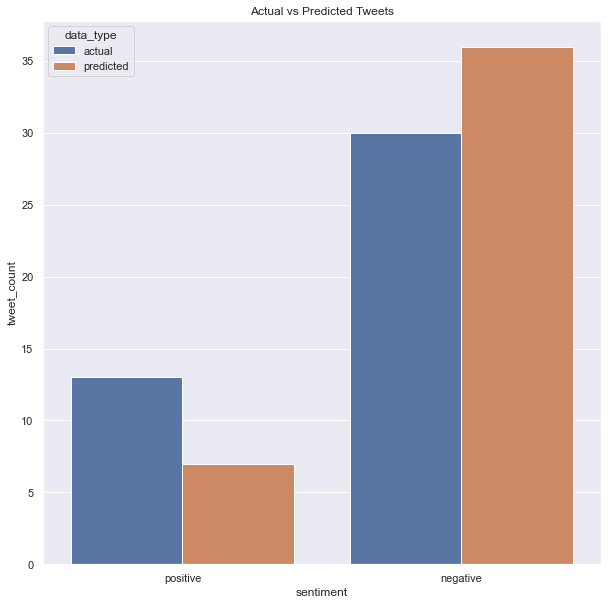

In [140]:
sns.barplot(data=prediction_comparison, x="sentiment", y="tweet_count", hue='data_type').set_title('Actual vs Predicted Tweets')
sns.set(rc={'figure.figsize':(1,10)})